In [1]:
%matplotlib inline

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

import pbio.utils.bed_utils as bed_utils
import pbio.misc.parallel as parallel
import pbio.misc.utils as utils

import pbio.misc.math_utils as math_utils

import pbio.ribo.ribo_utils as ribo_utils

In [57]:
def get_windows(profile):
    
    profile = profile / np.max(profile)
    
    orf_len = len(profile)
    if orf_len < 42:
        # we would return first window and exit
        first_window = profile[:21]
        return (first_window, None, None)

    first_window, middle_window, last_window = np.split(profile, [21, orf_len-21])

    # now, pull together and sum up all intermediate windows (of length 21)
    # cheat a bit, and just split split the middle into 21-bp windows, drop the last window
    indices = np.arange(21, len(middle_window), 21)
    middle_windows = np.split(middle_window, indices)[:-1]
    
    return first_window, middle_windows, last_window

def get_profile(orf, profiles):
    orf_num = orf['orf_num']
    orf_len = orf['orf_len']

    if orf_len < 21:
        return None

    profile = utils.to_dense(profiles, orf_num, length=orf_len)
    
    if sum(profile) < 5:
        return None
    
    return profile

def plot_rects(ind, means, variances, ax, ymax=0.5, fontsize=12, width=1):
    cm = plt.cm.Blues

    x_1 = means[0::3]
    x_2 = means[1::3]
    x_3 = means[2::3]
    
    x_1_var = variances[0::3]
    x_2_var = variances[1::3]
    x_3_var = variances[2::3]

    x_1_pos = np.arange(len(ind))[0::3]
    x_2_pos = np.arange(len(ind))[1::3]
    x_3_pos = np.arange(len(ind))[2::3]

    x_1_rects = ax.bar(x_1_pos, x_1, width=width, color=cm(0.8), yerr=x_1_var)
    x_2_rects = ax.bar(x_2_pos, x_2, width=width, color=cm(0.5), yerr=x_2_var)
    x_3_rects = ax.bar(x_3_pos, x_3, width=width, color=cm(0.2), yerr=x_2_var)

    ax.set_xticks(x_1_pos + width/2)
    ax.set_xticklabels(x_1_pos, fontsize=fontsize)
    
    ax.set_xlim((-width/2, len(ind)+width/2))
    ax.set_ylim((0, ymax))
    
    yticks = ax.yaxis.get_major_ticks()
    yticks[0].label1.set_visible(False)
    
def plot_windows(windows, axes, ymax=0.5):

    windows_np = np.array(windows)
    first_windows = windows_np[:,0]
    
    #print(first_windows)

    last_windows = windows_np[:,2] 
    last_windows = np.array([lw for lw in last_windows if lw is not None])

    middle_windows = windows_np[:,1] 
    middle_windows = [mw for mw in middle_windows if mw is not None]
    middle_windows = utils.flatten_lists(middle_windows)
    middle_windows = np.array(middle_windows)

    ind = np.arange(21)  # the x locations for the groups
    width = 0.5       # the width of the bars
    
    cm = plt.cm.Blues


    # the first window
    first_means = np.mean(first_windows, axis=0)
    first_var = np.var(first_windows, axis=0)
    plot_rects(ind, first_means, first_var, axes[0], ymax=ymax)
    
    #rects_first = axes[0].bar(ind, first_means, width, color=cm(0.8), yerr=first_var)

    # the middle windows
    middle_means = np.mean(middle_windows, axis=0)
    middle_var = np.var(middle_windows, axis=0)
    #rects_middle = axes[1].bar(ind, middle_means, width, color=cm(0.5), yerr=middle_var)
    plot_rects(ind, middle_means, middle_var, axes[1], ymax=ymax)

    # the last window
    last_means = np.mean(last_windows, axis=0)
    last_var = np.var(last_windows, axis=0)
    #rects_last = axes[2].bar(ind, last_means, width, color=cm(0.2), yerr=last_var)
    plot_rects(ind, last_means, last_var, axes[2], ymax=ymax)


In [5]:
#orfs_file = "/genomes/caenorhabditis_elegans/WBcel235.79.plus-de-novo/transcript-index/WBcel235.79.plus-de-novo.genomic-orfs.atg-only.bed.gz"
#profiles_file = "/prj/grosshans-riboseq/RPF/orf-profiles/9h-unique.length-17-20-21-28-29-33.offset-6-3-3-12-12-13.profiles.mtx"

#orfs_file = "/genomes/mus_musculus/GRCm38.79.plus-de-novo.genomic-orfs.atg-only.bed.gz"
#profiles_file = "/prj/shirin-riboseq/RPF/orf-profiles/mouse-325.swim.cm.de-novo-unique.length-25-29-30-32-33-34-35.offset-12-12-12-13-13-13-13.profiles.mtx"

#orfs_file = "/genomes/homo-sapiens/GRCh38.79.plus-de-novo.genomic-orfs.atg-only.bed.gz"
#profiles_file = "/prj/leo-riboseq/RPF/orf-profiles/tgfp-1-unique.length-17-18-19-20-21-22-23-24-26-28-29-30-31-32.offset-0-0-0-3-3-12-12-7-9-12-12-12-13-13.profiles.mtx"
orfs_file = "/genomes/homo-sapiens/GRCh38_79/transcript-index/GRCh38_79.genomic-orfs.aug-only.bed.gz"
orfs_file = "/prj/rpbp-paper/RPF/orf-predictions/hek293-unique.filtered.predicted-orfs.bed.gz"

profiles_file = "/prj/rpbp-paper/RPF/orf-profiles/hek293-unique.length-18-19-21-22-23-24-25-26-27-28-29-30-31.offset-12-12-12-12-12-12-12-12-12-12-12-12-13.profiles.mtx.gz"


profiles = scipy.io.mmread(profiles_file).tocsr()

/home/bmalone/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [61]:
orfs_file = "/prj/rpbp-paper/RPF/orf-predictions/hek293-unique.filtered.predicted-orfs.bed.gz"
sample_title = "HEK293"
orfs = bed_utils.read_bed(orfs_file)

100%|██████████| 2201/2201 [00:00<00:00, 13296.21it/s]
0it [00:00, ?it/s]
novel (0)
100%|██████████| 42/42 [00:00<00:00, 5671.26it/s]


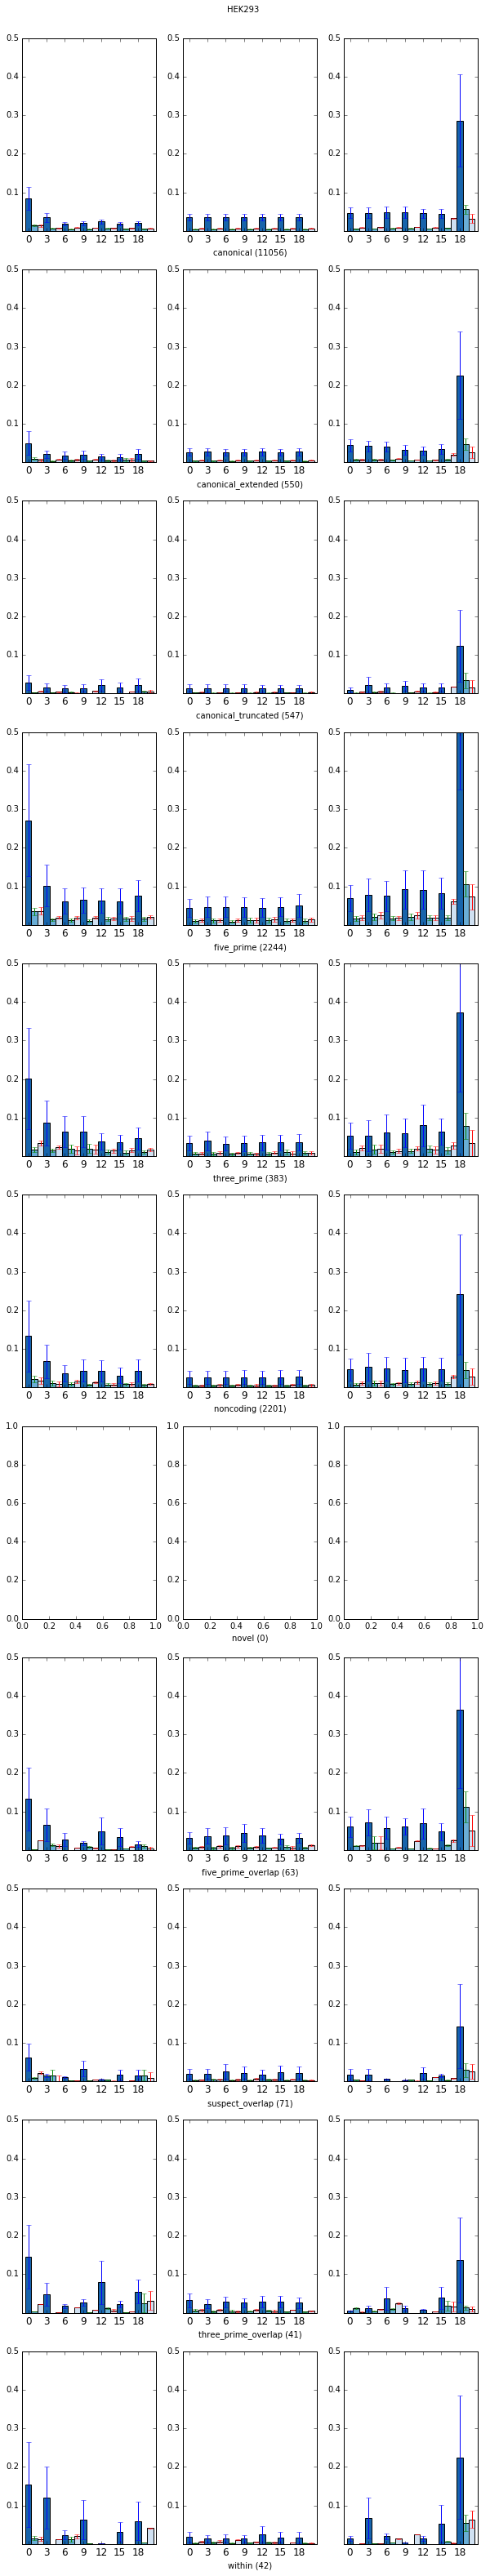

In [68]:
image_file = "/prj/rpbp-paper/paper-figures/orf-type-metagene-profiles.pdf"

orf_types = ribo_utils.orf_types

nrows = len(orf_types)
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(10,5*nrows)) # , sharey=True, sharex=True

for i, orf_type in enumerate(orf_types):
    m_orf_type = orfs['orf_type'] == orf_type
    g = orfs[m_orf_type]
    
    %xdel windows
    %xdel g_profiles
    g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
    g_profiles = [g_profile for g_profile in g_profiles if g_profile is not None]
    windows = parallel.apply_iter_simple(g_profiles, get_windows, progress_bar=True)

    title = '{} ({})'.format(orf_type, len(windows))
    axes[i, 1].set_xlabel(title)
    
    if len(windows) == 0:
        print(title)
        continue
    plot_windows(windows, axes[i])
    
suptitle = fig.suptitle(sample_title, y=0.91)
    
if image_file is not None:
    fig.savefig(image_file, bbox_inches='tight', bbox_extra_artists=(suptitle,))
    

100%|██████████| 194/194 [00:00<00:00, 11857.99it/s]


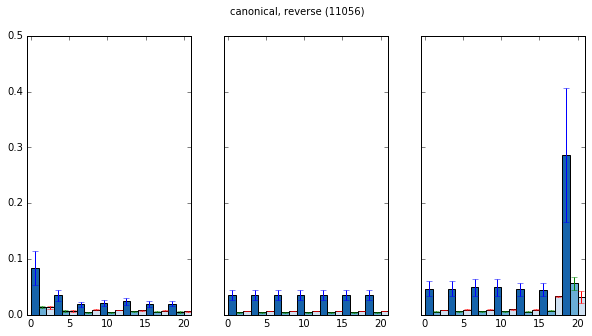

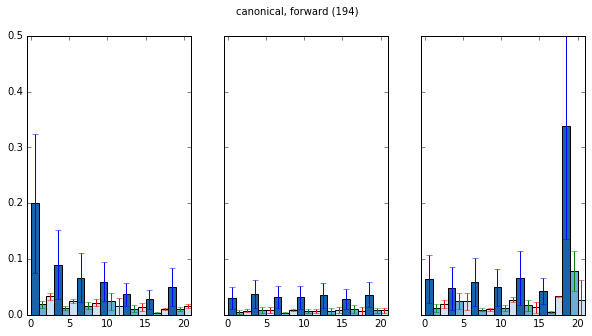

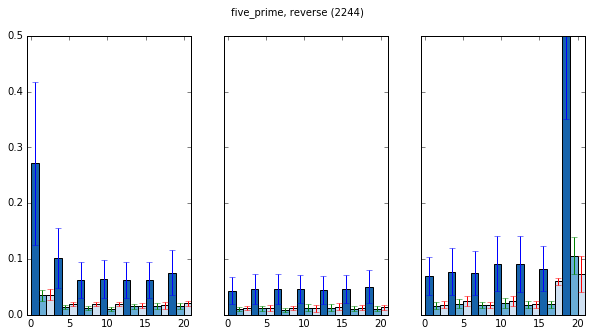

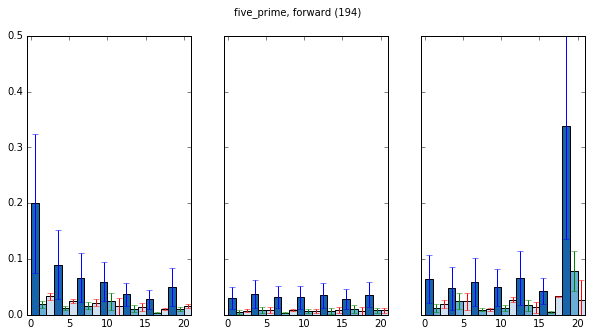

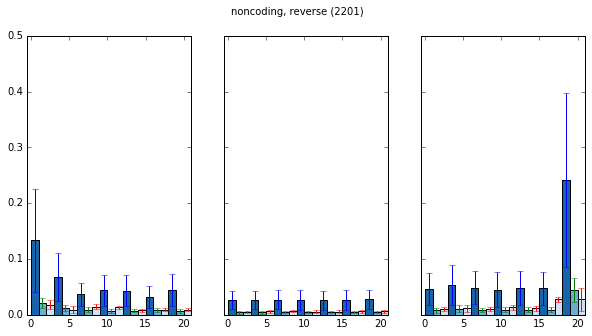

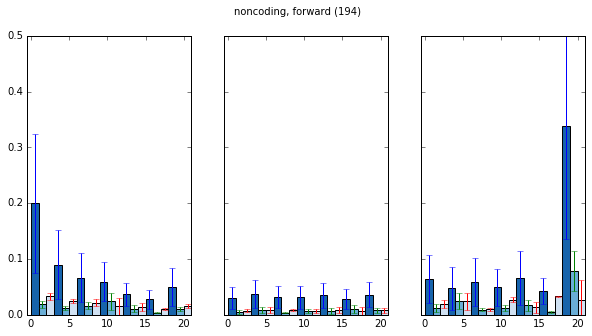

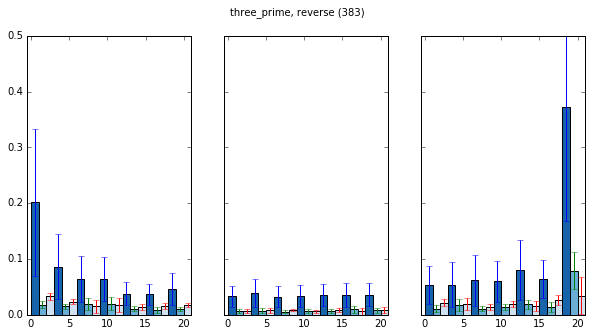

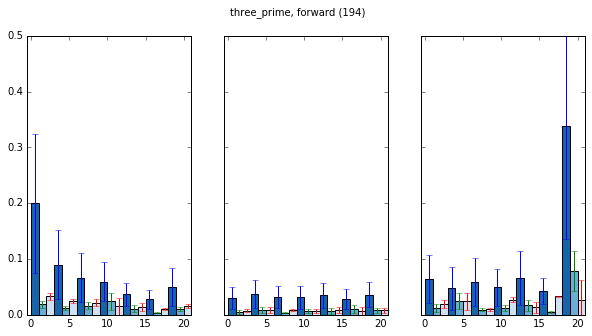

In [25]:
orf_types = ['canonical', 'five_prime', 'noncoding', 'three_prime'] # 'within']

for orf_type in orf_types:
    m_orf_type = orfs['orf_type'] == orf_type
    m_reverse = orfs['strand'] == '-'
    m_seqname = orfs['seqname'] == 'I'
    g = orfs[m_orf_type & m_reverse] # & m_seqname]
    
    %xdel windows
    %xdel g_profiles
    g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
    g_profiles = [g_profile for g_profile in g_profiles if g_profile is not None]
    windows = parallel.apply_iter_simple(g_profiles, get_windows, progress_bar=True)

    title = '{}, reverse ({})'.format(orf_type, len(windows))
    plot_windows(windows, title)
    
    %xdel windows
    %xdel g_profiles
    g = orfs[m_canonical & ~m_reverse] # & m_seqname]
    g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
    g_profiles = [g_profile for g_profile in g_profiles if g_profile is not None]
    windows = parallel.apply_iter_simple(g_profiles, get_windows, progress_bar=True)

    title = '{}, forward ({})'.format(orf_type, len(windows))
    plot_windows(windows, title)

In [5]:
orf_type = 'within'
m_canonical = orfs['orf_type'] == orf_type
m_reverse = orfs['strand'] == '-'
m_seqname = orfs['seqname'] == 'I'
g = orfs[m_canonical & m_reverse] # & m_seqname]


NameError: name 'windows' is not defined
NameError: name 'g_profiles' is not defined
100%|██████████| 16533/16533 [00:00<00:00, 18341.04it/s]


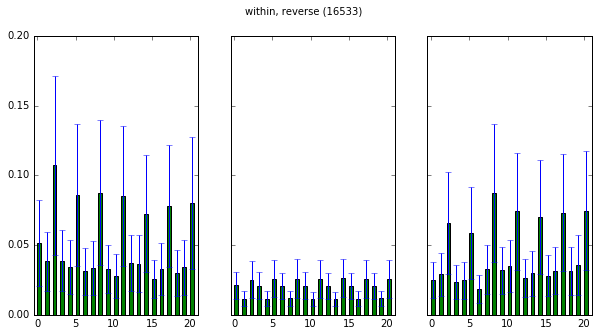

In [6]:
%xdel windows
%xdel g_profiles
g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
g_profiles = [g_profile for g_profile in g_profiles if g_profile is not None]
windows = parallel.apply_iter_simple(g_profiles, get_windows, progress_bar=True)

title = '{}, reverse ({})'.format(orf_type, len(windows))
plot_windows(windows, title)

100%|██████████| 7989/7989 [00:01<00:00, 6199.56it/s]


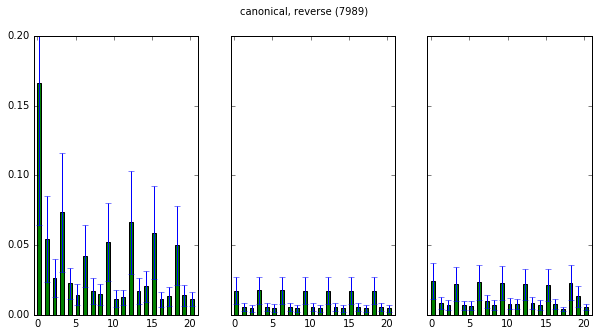

In [42]:
%xdel windows
%xdel g_profiles
g = orfs[m_canonical & ~m_reverse] # & m_seqname]
g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
g_profiles = [g_profile for g_profile in g_profiles if g_profile is not None]
windows = parallel.apply_iter_simple(g_profiles, get_windows, progress_bar=True)

title = '{}, forward ({})'.format(orf_type, len(windows))
plot_windows(windows, title)

In [ ]:
def run_all(g, profiles, num_cpus=2):
    orf_type = g['orf_type'].iloc[0]

    g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
    windows = parallel.apply_parallel_iter(g_profiles, num_cpus, get_windows, progress_bar=True)
    
    plot_windows(windows, orf_type)

In [ ]:
num_cpus = 2
orf_type_groups.apply(run_all, profiles, num_cpus)

In [ ]:
run_all(g, profiles)

In [ ]:
orf_type_groups.apply()

In [ ]:
run_all('canonical', orf_type_groups, profiles)

In [ ]:
run_all('five_prime_overlap', orf_type_groups, profiles)

In [ ]:
run_all('five_prime', orf_type_groups, profiles)

In [ ]:
run_all('three_prime_overlap', orf_type_groups, profiles)